In [2]:
import scanpy as sc
from scimilarity.utils import clean_tissues
import pandas as pd
import numpy as np

/home/debroue1/scratch/conda/envs/pascient/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [3]:
adata_train = sc.read_h5ad("/projects/site/gred/resbioai/liut61/adata_train_diseaseembeddings.h5ad")
adata_valid = sc.read_h5ad("/projects/site/gred/resbioai/liut61/adata_valid_diseaseembeddings.h5ad")
adata_test = sc.read_h5ad("/projects/site/gred/resbioai/liut61/adata_test_diseaseembeddings.h5ad")

In [4]:
adata = adata_train

In [5]:
adata = adata[adata.obs['tissue'] != '']

In [6]:
adata.obs['tissue_clean'] = clean_tissues(adata.obs['tissue'])
adata.obs['tissue_clean'] = adata.obs['tissue_clean'].astype('category')

/tmp/ipykernel_3742663/2726333434.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['tissue_clean'] = clean_tissues(adata.obs['tissue'])


In [7]:
dict_train_emb = {}
for i in ["Alzheimer's disease", 'B-cell acute lymphoblastic leukemia', 'COVID-19', "Crohn's disease", 'lung adenocarcinoma', 'melanoma', 'multiple myeloma', 'multiple sclerosis']:
    adata_new = adata[adata.obs['true'] == i]
    for j in adata_new.obs['tissue_clean'].unique():
        if str(j) != 'nan':
            adata_new_c = adata_new[adata_new.obs['tissue_clean']== j]
            dict_train_emb[str(i)+'-'+str(j)] = np.mean(adata_new_c.X, axis=0)

In [8]:
df = pd.DataFrame.from_dict(dict_train_emb)

In [9]:

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [10]:
import matplotlib.pyplot as plt

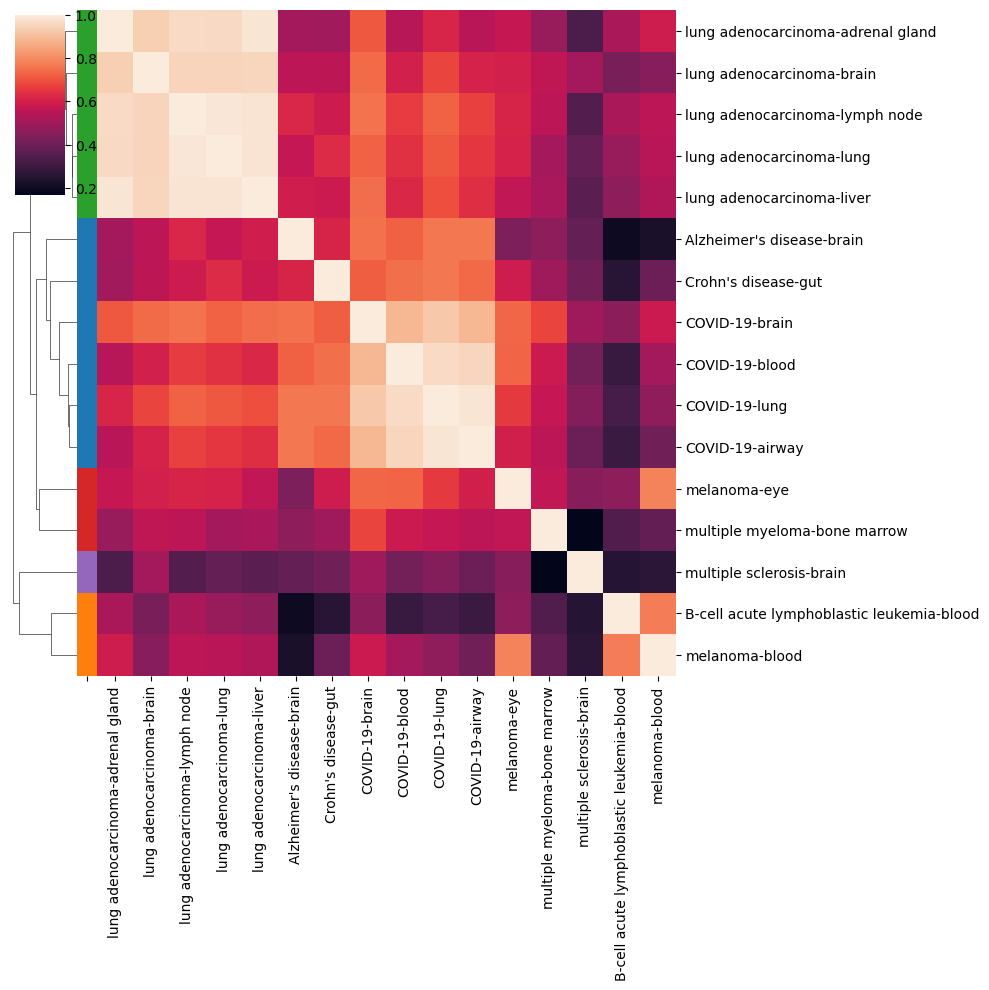

In [11]:
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree

# Generate some sample data
np.random.seed(0)
data = df.corr()

# Perform hierarchical clustering
linkage_matrix = linkage(data, method='average')

# Cut the tree to get a specific number of clusters (e.g., 4 clusters)
num_clusters = 5
clusters = cut_tree(linkage_matrix, n_clusters=num_clusters).flatten()

# Add the cluster information to the data for coloring
row_colors = pd.Series(clusters, index=data.index).map(dict(enumerate(sns.color_palette("tab10", num_clusters))))

# Plot a clustermap with the truncated dendrogram
sns.clustermap(data, row_colors=row_colors, method='average',dendrogram_ratio=(0.1,0))
# plt.savefig("./clustermap_diseasetissue.pdf", format='pdf')

In [12]:
adata = sc.concat([adata_train, adata_valid, adata_test], keys=['train', 'valid', 'test'], label='split')

/home/debroue1/scratch/conda/envs/pascient/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [13]:
sc.pp.neighbors(adata, use_rep='X')
sc.tl.umap(adata, random_state=0)

/home/debroue1/scratch/conda/envs/pascient/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
import latex
import os

os.environ['PATH'] += os.pathsep + '/apps/rocs/2020.08/sandybridge/software/texlive/20200406-GCCcore-9.3.0/bin/x86_64-linux'

plt.rcParams['text.usetex'] = True

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": "Helvetica",
    "text.latex.preamble": r"\usepackage{amsmath}"
})


In [15]:
map_dict = {"Alzheimer's disease": "Alzheimer's disease",
'B-cell acute lymphoblastic leukemia': "B-cell acute lymphoblastic leukemia",
'COVID-19': "COVID-19",
"Crohn's disease": "Crohn's disease",
'healthy': "Healthy",
'lung adenocarcinoma': "Lung adenocarcinoma",
'melanoma': "Melanoma",
'multiple myeloma': "Multiple myeloma",
'multiple sclerosis': "Multiple sclerosis"}

adata.obs["true"] = adata.obs["true"].map(map_dict)

In [16]:
import scimilarity
clean_out = scimilarity.utils.clean_tissues(adata.obs['tissue']).values
adata.obs['tissue_clean'] = [str(i) if str(i) != 'nan' else 'others' for i in clean_out]

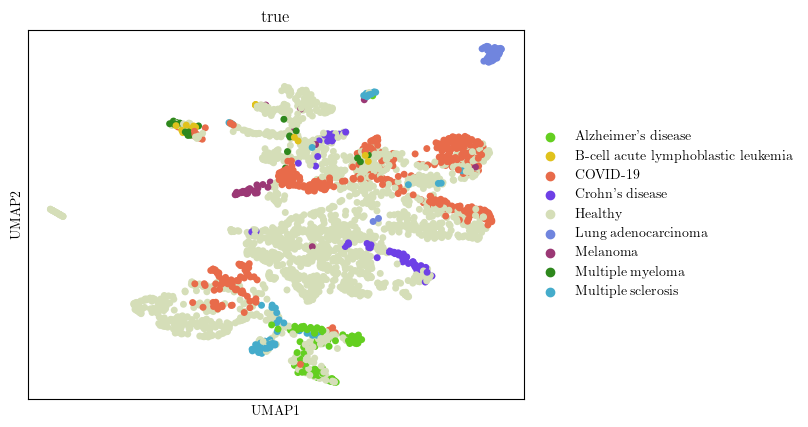

In [17]:
import matplotlib.pyplot as plt
import scanpy as sc

# Define the color map for your labels
color_map = {
    'Healthy': '#d5deb8',#'#ccd6ab',
    'COVID-19': '#e86b4a',
    'Multiple sclerosis': '#45accb',
    "Crohn's disease": '#6e40e6',
    'Melanoma': '#9b3875',
    "Alzheimer's disease": '#64cf20',
    'Lung adenocarcinoma': '#7085de',
    'B-cell acute lymphoblastic leukemia':"#e0c21c",
    'Multiple myeloma':"#2e881d"
}

# Ensure that all labels in 'true' have a color assigned
categories = adata.obs['true'].cat.categories
palette = [color_map.get(label, 'gray') for label in categories]  # Default color is gray for any unspecified labels

# Plot UMAP with the custom palette
sc.pl.umap(adata, color=['true'], palette=palette,s = 100, save = "umap_disease.pdf") 

In [18]:
#remove categorical 
adata.obs["true"] = adata.obs["true"].astype(str)
adata.obs.loc[(adata.obs["true"] == "COVID-19") & (adata.obs["tissue_clean"] == "lung"), "true"] = "COVID-19 (lung)"
adata.obs.loc[(adata.obs["true"] == "COVID-19") & (adata.obs["tissue_clean"] == "blood"), "true"] = "COVID-19 (blood)"
adata.obs.loc[(adata.obs["true"] == "COVID-19"), "true"] = "COVID-19 (other)"

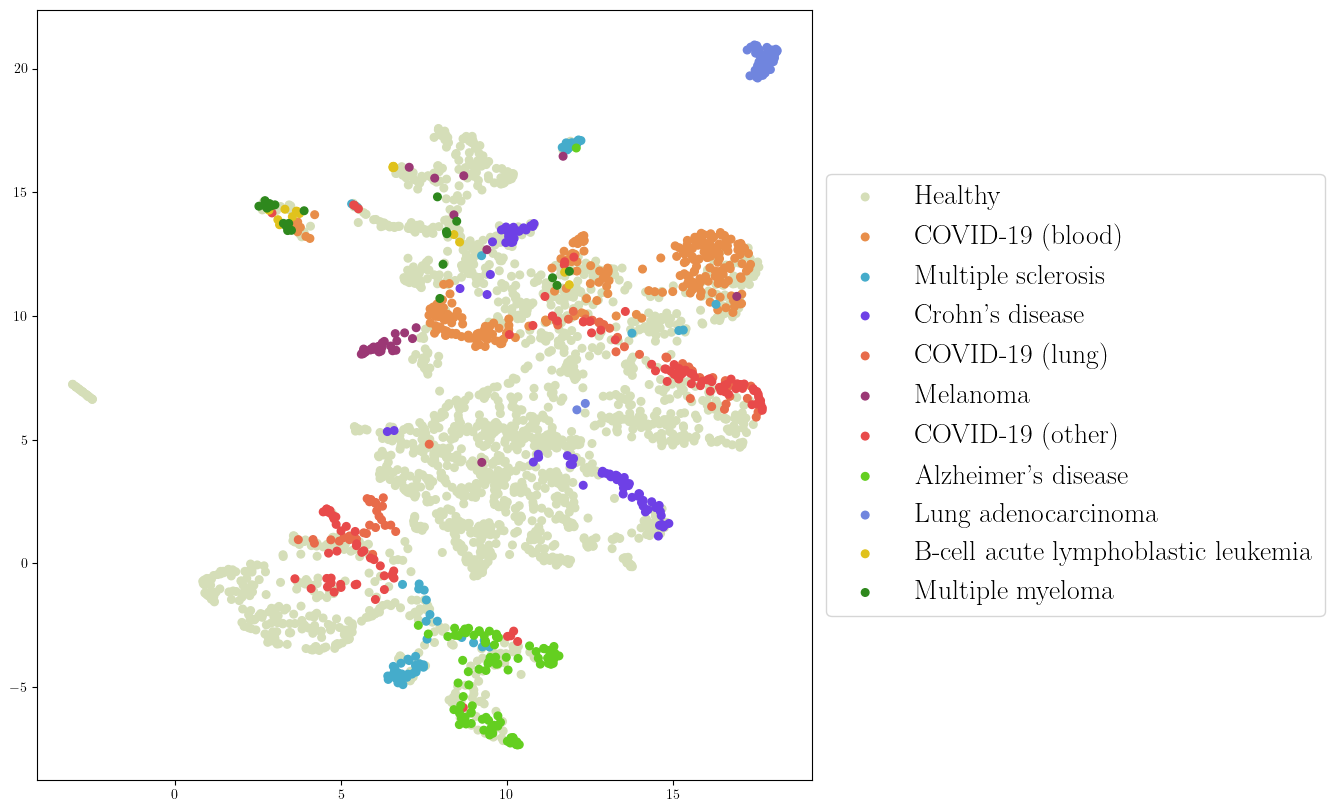

In [19]:
color_map = {
    'Healthy': '#d5deb8',#'#ccd6ab',
    'COVID-19 (lung)': '#e86b4a',
    'COVID-19 (blood)': '#e88e4a',
    'COVID-19 (other)': '#e84a4a',
    'Multiple sclerosis': '#45accb',
    "Crohn's disease": '#6e40e6',
    'Melanoma': '#9b3875',
    "Alzheimer's disease": '#64cf20',
    'Lung adenocarcinoma': '#7085de',
    'B-cell acute lymphoblastic leukemia':"#e0c21c",
    'Multiple myeloma':"#2e881d"
}


plt.figure(figsize=(10, 10))
for disease_state in adata.obs["true"].unique():
    adata_sub = adata[adata.obs["true"]==disease_state]
    plt.scatter(adata_sub.obsm["X_umap"][:, 0], adata_sub.obsm["X_umap"][:, 1], c = [color_map[disease_state]]*adata_sub.shape[0], s = 30)
    plt.legend(adata.obs["true"].unique(),fontsize = 20, loc = 'center left', bbox_to_anchor=(1, 0.5))
plt.savefig("./figures/umap_disease_new.pdf")

In [20]:
adata.obs["tissue_clean"].cat.categories

map_dict = {'adipose': 'Adipose',
            'adrenal gland': "Adrenal gland",
              'airway': "Airway",
                'bladder': "Bladder",
                  'blood': "Blood",
                    'bone': "Bone",
       'bone marrow': "Bone marrow",
         'brain': "Brain",
           'breast': "Breast",
             'esophagus': "Esophagus",
               'eye': "Eye",
       'female reproduction': 'Female Reproduction',
         'gut': "Gut",
           'heart': "Heart",
             'kidney': "Kidney",
               'liver': "Liver",
                 'lung': "Lung",
       'lymph node':   "Lymph node",
         'male reproduction': "Male reproduction",
           'others': "Other",
             'pancreas': "Pancreas",
               'skin': "Skin",
       'spleen': "Spleen",
         'stomach': "Stomach",
           'thymus': "Thymus",
             'vasculature': "Vasculature"}

adata.obs["tissue_clean"] = adata.obs["tissue_clean"].map(map_dict)

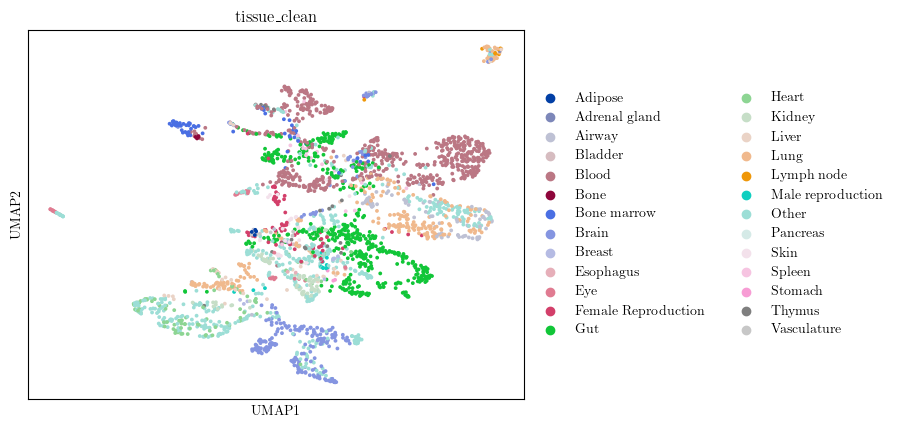

In [21]:
sc.pl.umap(adata, color=['tissue_clean'], s= 30, save = "umap_tissue.pdf")

In [33]:
print(list(adata.obs["tissue_clean"].unique()))

['Female Reproduction', 'Other', 'Blood', 'Gut', 'Brain', 'Liver', 'Lung', 'Heart', 'Kidney', 'Airway', 'Bone marrow', 'Skin', 'Adrenal gland', 'Spleen', 'Lymph node', 'Eye', 'Bladder', 'Breast', 'Thymus', 'Male reproduction', 'Stomach', 'Pancreas', 'Vasculature', 'Esophagus', 'Adipose', 'Bone']


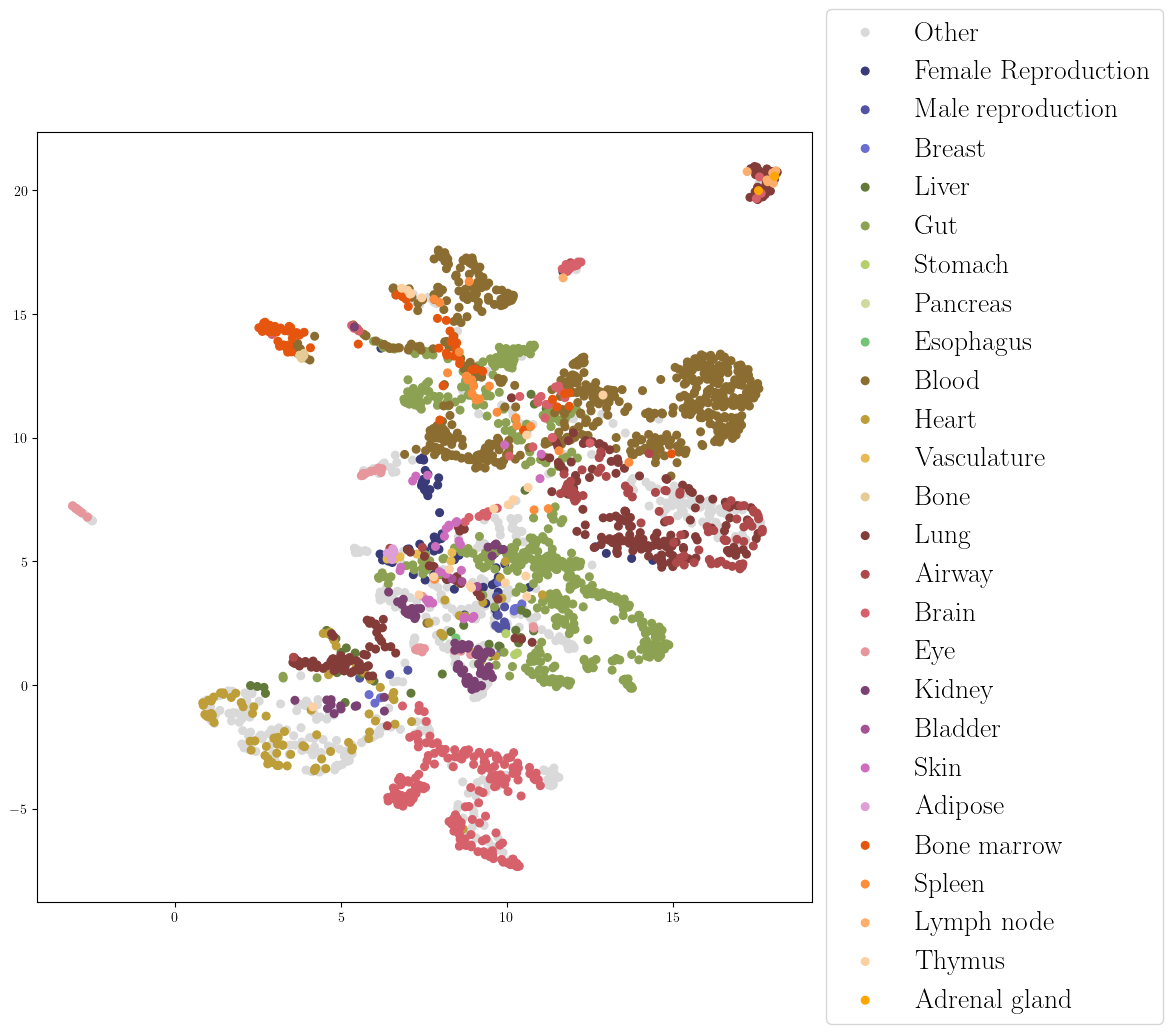

In [50]:
tissues_list = ['Other', 
                'Female Reproduction',
                 'Male reproduction' ,
                'Breast' ,
                
                 'Liver',
                'Gut',
                'Stomach',
                'Pancreas',
                'Esophagus',
                
                'Blood',
                'Heart',
                'Vasculature',
                
                'Bone',
                
                'Lung' ,
                 'Airway',
                
                 'Brain',
                'Eye',

                'Kidney',
                'Bladder',
                
                'Skin',
                'Adipose',

                'Bone marrow',
                'Spleen' ,
                'Lymph node',
                'Thymus',

                'Adrenal gland']

cmap = plt.colormaps["tab20b"]
cmapc = plt.colormaps["tab20c"]

colors_tissue = { 'Other': cmapc(19),
    
                'Female Reproduction': cmap(0),
                 'Male reproduction' : cmap(1),
                'Breast' : cmap(2),
                
                 'Liver': cmap(4),
                'Gut': cmap(5),
                'Stomach': cmap(6),
                'Pancreas': cmap(7),
                'Esophagus': cmapc(9),
                
                'Blood': cmap(8),
                'Heart': cmap(9),
                'Vasculature': cmap(10),
                
                'Bone': cmap(11),
                
                'Lung' : cmap(12),
                 'Airway': cmap(13),
                
                 'Brain': cmap(14),
                'Eye': cmap(15),

                'Kidney': cmap(16),
                'Bladder': cmap(17),
                
                'Skin': cmap(18),
                'Adipose': cmap(19),

                'Bone marrow': cmapc(4),
                'Spleen' : cmapc(5),
                'Lymph node': cmapc(6),
                'Thymus': cmapc(7),

                'Adrenal gland': "orange",

                }


plt.figure(figsize=(10, 10))
for i_t, tissue in enumerate(tissues_list):
    adata_sub = adata[adata.obs["tissue_clean"]==tissue]
    plt.scatter(adata_sub.obsm["X_umap"][:, 0], adata_sub.obsm["X_umap"][:, 1], c = [colors_tissue[tissue]]*adata_sub.shape[0], s = 30)
    plt.legend(tissues_list,fontsize = 20, loc = 'center left', bbox_to_anchor=(1, 0.5))
plt.savefig("./figures/umap_tissue_new.pdf")

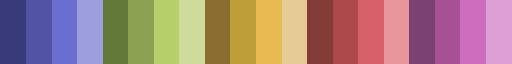

In [44]:
cmap